In [1]:
pip install image-classifiers

In [2]:
"""Adapted from keras example cifar10_cnn.py
Train ResNet-18 on the CIFAR10 small images dataset.
GPU run command with Theano backend (with TensorFlow, the GPU is automatically used):
"""

## Imports and initializations
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.models import model_from_json
import cv2
import keras.backend as K
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np

# mount the google drive to your Colab session
from google.colab import drive
dir="/content/gdrive/My Drive/Colab Notebooks/EIP2/"
drive.mount('/content/gdrive')
!ls

# Hyperparameters
batch_size = 256
nb_classes = 10

# input image dimensions
img_rows, img_cols = 32, 32
# The imagenet images are RGB.
img_channels = 3

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive	sample_data


### Creation of base model pretrained with weights from imagenet
https://github.com/qubvel/classification_models.git

### Loading of CIFAR10 Data (32x32x3)

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print(x_train.shape, x_test.shape)
print(y_train.shape)

# convert to one hot encoing 
y_train = keras.utils.to_categorical(y_train, nb_classes)
y_test = keras.utils.to_categorical(y_test, nb_classes)
print(y_train.shape)

(50000, 32, 32, 3) (10000, 32, 32, 3)
(50000, 1)
(50000, 10)


In [4]:
# load json and get saved model
json_file = open(dir + "Resnet18Model.json", 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
#model.summary()

W0710 09:35:11.592186 139990036363136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0710 09:35:11.632745 139990036363136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0710 09:35:11.634142 139990036363136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0710 09:35:11.638447 139990036363136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0710 09:35:11.640613 139990

In [5]:
model.load_weights(dir + "Resnet18.10-0.80.hdf5")
print("Loaded model from disk ", model.summary())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
score = model.evaluate(x_test, y_test, verbose=1)
print(score)

W0710 09:35:27.182855 139990036363136 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

### Get index of 50 misclassified images

In [0]:
def get_incorrect_im(x_test):
  test_classes = np.argmax(y_test, axis=1)
  
  y_pred = model.predict(x_test)
  pred_classes = np.argmax(y_pred, axis=1)

  incorrect_im = (test_classes != pred_classes) #.astype(int)
  
  incorrect_idx_list = [i for i, j in enumerate(incorrect_im) if j == True]
  idx_list = incorrect_idx_list[:50]
  return idx_list

 ### Gradcam - Gradient weighted Class Activation Map

In [0]:
def get_activation_heatmap(img_idx, model):
  # preprocess normalizes image by subtracting mean RGB values from the input image
  # After expansion, shape : (1, 32, 32, 3)
  x = np.expand_dims(x_test[img_idx], axis=0)
  im_proc = preprocess_input(x)
  
  pred_val = model.predict(im_proc)
  pred_class_idx = np.argmax(pred_val)
  #print(img_idx, " Class pred ", pred_class_idx)

  # Compute map for the topmost class, class_output shape=(?,)
  class_output = model.output[:, pred_class_idx]
    
  layer_name = "stage2_unit2_conv2"
  layer_for_gradcam = model.get_layer(layer_name)
  #print("layer_for_gradcam", layer_for_gradcam.output.shape)
  
  grads = K.gradients(class_output, layer_for_gradcam.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, layer_for_gradcam.output[0]])

  pooled_grads_value, conv_layer_output_value = iterate([x])

  for i in range(128):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

  #print("After for loop", conv_layer_output_value.shape)
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)
  heatmap = cv2.resize(heatmap, (32,32))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
  return heatmap

Get heatmap and plot the superimposed image of **misclassified ones**

50 [2, 15, 20, 24, 25, 30, 32, 35, 37, 42]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in true_divide


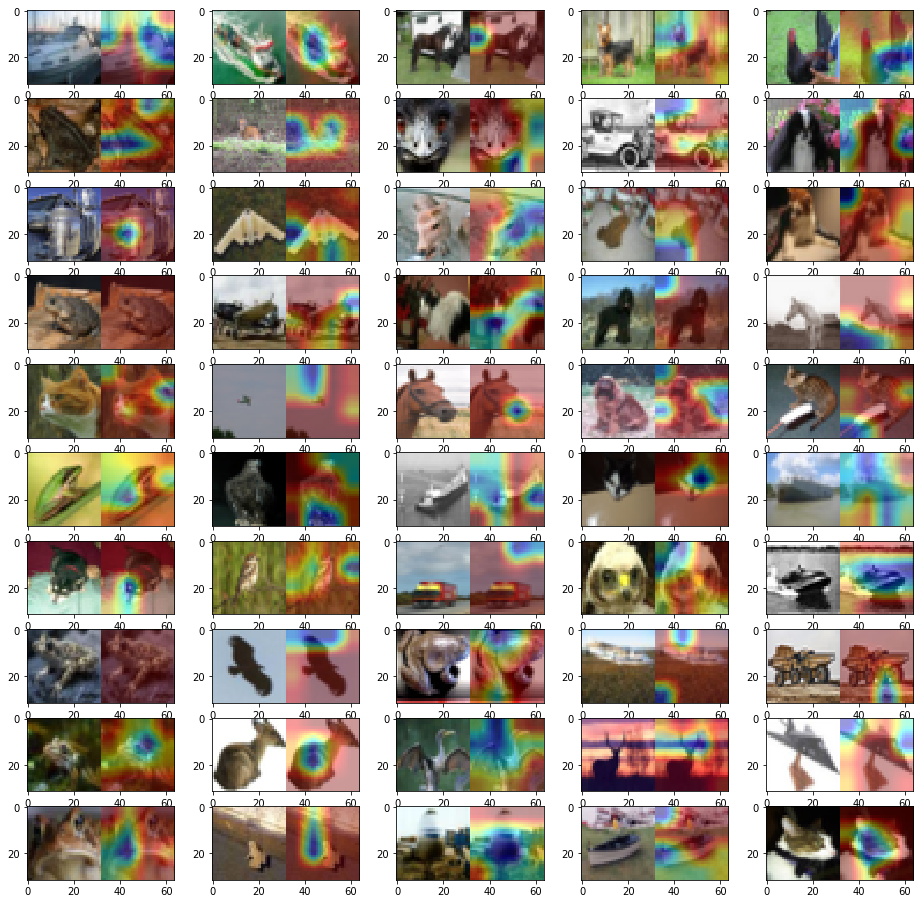

In [12]:
incorrect_idx_list = get_incorrect_im(x_test)
print(len(incorrect_idx_list), incorrect_idx_list[:10])
fig = plt.figure(figsize=(16, 16)) # width,height

for idx, val in enumerate(incorrect_idx_list):
  heatmap = get_activation_heatmap(val, model)
  #print(idx, val)
  # Calculate the weighted sum of image and heatmap
  superimposed_img = cv2.addWeighted(x_test[val], 0.6, heatmap, 0.4, 0)
  final_im = cv2.hconcat([x_test[val], superimposed_img])

  # Plot the concatenanted original and superimposed images
  sub = fig.add_subplot(10, 5, idx+1) # nrows, ncols, index
  sub.imshow(final_im)